In [1]:
import os
os.getpid()

14324

In [2]:
# Parse Tree

# Notice: there is no need for using data loader

# Adam optimizer and NN models are still necessary

# During training, we simplely traverse through the list of object

# Notice that the label is binary. Instead of MLE, we can do a logistic regression with BCE loss.

# Module 1
## Data Preprocessing and Parsing. 
## Each entry is a tuple (label, parse tree of predicate)

In [3]:
import torch

with open("ALCIR-data-parsesupervise.txt") as file:
    lines = file.readlines()
with open("ALCIR-data-parsesupervise-10k.txt") as file2:
    lines2 = file2.readlines()
    
for line_index in range(len(lines)):
    lines[line_index] = lines[line_index].split("\t")
    lines[line_index].pop(2)
    
for line_index in range(len(lines2)):
    lines2[line_index] = lines2[line_index].split("\t")
    lines2[line_index].pop(2)
    
    # Training set and Testing set splited here.

lenth = len(lines2)
import random
random.seed(10)
random.shuffle(lines2)
train_list = lines2[0:int(lenth*0.8)]
test_list = lines2[int(lenth*0.8):]
lenth = len(lines)
train_list_short = lines[0:int(lenth*0.8)]
test_list_short = lines[int(lenth*0.8):]
print("train_len: ", len(train_list))
count = 0
for i in train_list:
    if i[0] == "satisfiable":
        count += 1  
print("count: ", count)



from pythonds.basic import Stack
from pythonds.trees import BinaryTree

# add 'o' as operater placeholder
def convert (p):
    p = p.split()
    fix = 0
    for i in range(len(p)-1):
        if p[i+fix] in ['q', '|', '&', ')', '=>', '~', 'p', '<=>']:
            if p[i+1+fix] in ['(', 'q', '|', '&', '=>', '~', 'p', '<=>']:
                p.insert(i+1+fix, 'o')
                fix += 1
    return p

# build a parse tree for a predicate. The o is placeholder of operator
# During nn train, the o is replace by real value. 
# The o at the root, passing through the sigmoid function, is the output of nn
def buildParseTree(fpexp):
    fplist = convert(fpexp)
    # print(fplist)
    pStack = Stack()
    eTree = BinaryTree('')
    pStack.push(eTree)
    currentTree = eTree

    for i in fplist:
        if i == '(':
            currentTree.insertLeft('')
            pStack.push(currentTree)
            currentTree = currentTree.getLeftChild()

        elif i in ['o']:
            currentTree.setRootVal(i)
            currentTree.insertRight('')
            pStack.push(currentTree)
            currentTree = currentTree.getRightChild()

        elif i == ')':
            currentTree = pStack.pop()

        elif i not in ['o' ')']:

            currentTree.setRootVal(i)
            parent = pStack.pop()
            currentTree = parent


    return eTree

from tqdm import tqdm
# Return a list of tuple, used for training
#   first element is -1 if unsatisiable, 1 if satisiable
#   second element is a Tree object
def makeTrainData():
    l = []
    for i in tqdm(train_list):
        label = 0.0
        if i[0] == 'satisfiable':
            label = 1.0
        ptree = buildParseTree(i[1])
        l.append((label, ptree))
    return l
        
        
        
# Return a list of tuple, used for testing
#   first element is -1 if unsatisiable, 1 if satisiable
#   second element is a Tree object
def makeTestData():
    l = []
    for i in tqdm(test_list):
        label = 0.0
        if i[0] == 'satisfiable':
            label = 1.0
        ptree = buildParseTree(i[1])
        l.append((label, ptree))
    return l

train_data = makeTrainData()
test_data = makeTestData()

corpora = {'q':torch.tensor(0), '|':torch.tensor(1), 
           '&':torch.tensor(2), '=>':torch.tensor(3), 
           '~':torch.tensor(4), 'p':torch.tensor(5), 
           '<=>':torch.tensor(6)}

train_len:  8000
count:  4005


100%|██████████| 2000/2000 [00:00<00:00, 9375.10it/s]


# Module 2
## Neural Network
## An implementation of the RNN from "RNN can Learn Logical Semantics"

In [4]:
from torch import embedding, nn


class TreeRNNPredictor(nn.Module):
    def __init__(self, feature_dim=75, input_dim=7):
        """
        :param input_dim: size of the vocabulary (number of unique tokens) = 7
        :param feature_dim mentioned in the paper, which set up to 75
        """
        super().__init__()


        self.embedding = nn.Embedding(input_dim, feature_dim)
        self.matrix_m = nn.Linear(feature_dim*2, feature_dim)
        self.fc_output = nn.Linear(feature_dim, 1)

    # Compute vectors bottom-up
    # Return the vector of in the root
    def traverse_tree(self, tree):
        
        if not tree.isLeaf():
            l = tree.getLeftChild()
            r = tree.getRightChild()
            tree.key = torch.sigmoid(self.matrix_m(torch.cat((self.traverse_tree(l),self.traverse_tree(r)))))
        else:
            emb = self.embedding(corpora[tree.key])
            return emb
            
        return tree.key
    
    

    # Instead of tanh, the sigmoid will be used.
    # The BCEloss will be used as loss function for regression.
    def forward(self, src):
        """

        :param src: a tree object.       
        :return: the prediction from 0 to 1. 
        """

        root = self.traverse_tree(src)
        z = self.fc_output(root)
        
        return torch.sigmoid(z)


In [5]:
from torch import optim
predictor = TreeRNNPredictor()
# as what said in the paper
def init_weights(model):
    for name, param in model.named_parameters():
        nn.init.uniform_(param.data, -0.05, 0.05)
predictor.apply(init_weights)

optimizer = optim.Adam(predictor.parameters())

# Different than paper, here using sigmoid instead of tanh
criterion = nn.BCELoss(reduction = 'sum')


N_EPOCHS = 5
CLIP = 1

best_test_loss = float('inf')

training_losses = []
test_losses = []



# Module 3
## Training (skip if you are evaluating only)

In [79]:

num_epochs_train = 0
def train(model, optimizer, criterion, clip):
    global num_epochs_train
    model.train()
    
    # Tuning of lr happens here
    tmp = optimizer.state_dict()
    tmp["param_groups"][0]["lr"] = 0.001/(1.9*(num_epochs_train+1))
    optimizer.load_state_dict(tmp)
    
    epoch_loss = 0
    num_batchs = 0
    total = 0


    # Apparently, batch_size == 1
    for i, batch in tqdm(enumerate(train_data)):
        
        optimizer.zero_grad()

        
        z = predictor.forward(batch[1])
        loss = 0
        
        #print(torch.tensor(z.item()),torch.tensor(batch[0]))
        loss = criterion(z, torch.tensor([batch[0]]))
        loss.backward()
        # Clips gradient norm of an iterable of parameters.
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        total += 1

    return epoch_loss /total

confusion_matrix = []
num_epochs = 0

def evaluate(model, criterion):
    
    model.eval()
    epoch_loss = 0
    total = 0
    confusion_matrix.append(torch.zeros(2,2))
    global num_epochs
    for i, batch in tqdm(enumerate(test_data)):
        z = predictor.forward(batch[1])
        loss = 0
        loss = criterion(z, torch.tensor([batch[0]]))
        
        epoch_loss += loss.item()
        total += 1
        
        # Load in confusion_matrix
        for i in range(1):
            
            row = int(batch[0])
            col = int(z+0.5)
            confusion_matrix[num_epochs][row][col] += 1
     
    num_epochs += 1
        
    return epoch_loss/total

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs




In [115]:
import time
N_EPOCHS = 50
best_test_loss = float('inf')
for epoch in range(N_EPOCHS):  
    print("epoch start: ", epoch)  
    start_time = time.time()
    training_loss = train(predictor, optimizer, criterion, CLIP)
    training_losses.append(training_loss)
    test_loss = evaluate(predictor, criterion)
    test_losses.append(test_loss)  
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    if test_loss < best_test_loss:
        best_test_loss = test_loss 
        torch.save(predictor.state_dict(), 'best_treeRNN.pt')
        

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s', end='')
    print(f'\tTrain Loss: {training_loss:.3f} | Test Loss: {test_loss:.3f}')


epoch start:  0


8000it [00:23, 337.14it/s]
2000it [00:02, 800.31it/s]


Epoch: 01 | Time: 0m 26s	Train Loss: 0.235 | Test Loss: 0.333
epoch start:  1


8000it [00:24, 326.50it/s]
2000it [00:02, 811.88it/s]


Epoch: 02 | Time: 0m 26s	Train Loss: 0.232 | Test Loss: 0.330
epoch start:  2


8000it [00:24, 331.72it/s]
2000it [00:03, 661.60it/s]


Epoch: 03 | Time: 0m 27s	Train Loss: 0.230 | Test Loss: 0.330
epoch start:  3


8000it [00:25, 317.99it/s]
2000it [00:02, 843.14it/s]


Epoch: 04 | Time: 0m 27s	Train Loss: 0.240 | Test Loss: 0.329
epoch start:  4


8000it [00:23, 347.19it/s]
2000it [00:02, 840.15it/s]


Epoch: 05 | Time: 0m 25s	Train Loss: 0.237 | Test Loss: 0.332
epoch start:  5


8000it [00:19, 403.21it/s]
2000it [00:01, 1024.67it/s]


Epoch: 06 | Time: 0m 21s	Train Loss: 0.235 | Test Loss: 0.334
epoch start:  6


8000it [00:18, 427.93it/s]
2000it [00:01, 1026.77it/s]


Epoch: 07 | Time: 0m 20s	Train Loss: 0.222 | Test Loss: 0.332
epoch start:  7


8000it [00:18, 433.65it/s]
2000it [00:01, 1019.93it/s]


Epoch: 08 | Time: 0m 20s	Train Loss: 0.231 | Test Loss: 0.339
epoch start:  8


8000it [00:18, 428.38it/s]
2000it [00:01, 1027.41it/s]


Epoch: 09 | Time: 0m 20s	Train Loss: 0.231 | Test Loss: 0.336
epoch start:  9


8000it [00:18, 427.01it/s]
2000it [00:02, 991.53it/s] 


Epoch: 10 | Time: 0m 20s	Train Loss: 0.228 | Test Loss: 0.338
epoch start:  10


8000it [00:18, 421.96it/s]
2000it [00:02, 986.35it/s] 


Epoch: 11 | Time: 0m 20s	Train Loss: 0.226 | Test Loss: 0.338
epoch start:  11


8000it [00:19, 420.62it/s]
2000it [00:02, 986.22it/s] 


Epoch: 12 | Time: 0m 21s	Train Loss: 0.225 | Test Loss: 0.337
epoch start:  12


8000it [00:18, 427.57it/s]
2000it [00:02, 986.09it/s] 


Epoch: 13 | Time: 0m 20s	Train Loss: 0.211 | Test Loss: 0.342
epoch start:  13


8000it [00:18, 427.54it/s]
2000it [00:01, 1001.66it/s]


Epoch: 14 | Time: 0m 20s	Train Loss: 0.212 | Test Loss: 0.343
epoch start:  14


8000it [00:18, 429.42it/s]
2000it [00:02, 995.03it/s] 


Epoch: 15 | Time: 0m 20s	Train Loss: 0.207 | Test Loss: 0.338
epoch start:  15


8000it [00:18, 426.78it/s]
2000it [00:02, 988.24it/s] 


Epoch: 16 | Time: 0m 20s	Train Loss: 0.205 | Test Loss: 0.337
epoch start:  16


8000it [00:18, 427.28it/s]
2000it [00:02, 992.88it/s] 


Epoch: 17 | Time: 0m 20s	Train Loss: 0.203 | Test Loss: 0.336
epoch start:  17


8000it [00:18, 429.07it/s]
2000it [00:01, 1017.58it/s]


Epoch: 18 | Time: 0m 20s	Train Loss: 0.201 | Test Loss: 0.326
epoch start:  18


8000it [00:18, 428.71it/s]
2000it [00:02, 993.25it/s] 


Epoch: 19 | Time: 0m 20s	Train Loss: 0.202 | Test Loss: 0.323
epoch start:  19


8000it [00:18, 429.31it/s]
2000it [00:02, 995.47it/s] 


Epoch: 20 | Time: 0m 20s	Train Loss: 0.198 | Test Loss: 0.331
epoch start:  20


8000it [00:18, 432.68it/s]
2000it [00:01, 1016.78it/s]


Epoch: 21 | Time: 0m 20s	Train Loss: 0.195 | Test Loss: 0.334
epoch start:  21


8000it [00:18, 428.05it/s]
2000it [00:01, 1002.60it/s]


Epoch: 22 | Time: 0m 20s	Train Loss: 0.195 | Test Loss: 0.329
epoch start:  22


8000it [00:18, 430.71it/s]
2000it [00:01, 1004.84it/s]


Epoch: 23 | Time: 0m 20s	Train Loss: 0.194 | Test Loss: 0.333
epoch start:  23


8000it [00:18, 430.65it/s]
2000it [00:01, 1001.48it/s]


Epoch: 24 | Time: 0m 20s	Train Loss: 0.190 | Test Loss: 0.338
epoch start:  24


8000it [00:18, 425.62it/s]
2000it [00:02, 980.42it/s] 


Epoch: 25 | Time: 0m 20s	Train Loss: 0.190 | Test Loss: 0.341
epoch start:  25


8000it [00:18, 428.93it/s]
2000it [00:01, 1014.15it/s]


Epoch: 26 | Time: 0m 20s	Train Loss: 0.187 | Test Loss: 0.332
epoch start:  26


8000it [00:18, 429.88it/s]
2000it [00:02, 976.16it/s] 


Epoch: 27 | Time: 0m 20s	Train Loss: 0.188 | Test Loss: 0.351
epoch start:  27


8000it [00:19, 415.67it/s]
2000it [00:01, 1001.04it/s]


Epoch: 28 | Time: 0m 21s	Train Loss: 0.187 | Test Loss: 0.349
epoch start:  28


8000it [00:19, 411.57it/s]
2000it [00:02, 854.09it/s]


Epoch: 29 | Time: 0m 21s	Train Loss: 0.186 | Test Loss: 0.357
epoch start:  29


8000it [00:20, 387.19it/s]
2000it [00:02, 755.57it/s]


Epoch: 30 | Time: 0m 23s	Train Loss: 0.185 | Test Loss: 0.346
epoch start:  30


8000it [00:20, 391.80it/s]
2000it [00:02, 976.54it/s] 


Epoch: 31 | Time: 0m 22s	Train Loss: 0.182 | Test Loss: 0.347
epoch start:  31


8000it [00:19, 409.70it/s]
2000it [00:02, 982.11it/s] 


Epoch: 32 | Time: 0m 21s	Train Loss: 0.180 | Test Loss: 0.401
epoch start:  32


8000it [00:19, 411.75it/s]
2000it [00:02, 986.14it/s] 


Epoch: 33 | Time: 0m 21s	Train Loss: 0.181 | Test Loss: 0.396
epoch start:  33


8000it [00:19, 415.07it/s]
2000it [00:02, 985.86it/s] 


Epoch: 34 | Time: 0m 21s	Train Loss: 0.181 | Test Loss: 0.401
epoch start:  34


8000it [00:19, 412.17it/s]
2000it [00:02, 997.24it/s] 


Epoch: 35 | Time: 0m 21s	Train Loss: 0.178 | Test Loss: 0.418
epoch start:  35


8000it [00:19, 413.72it/s]
2000it [00:02, 961.37it/s]


Epoch: 36 | Time: 0m 21s	Train Loss: 0.179 | Test Loss: 0.406
epoch start:  36


8000it [00:19, 412.68it/s]
2000it [00:02, 997.88it/s] 


Epoch: 37 | Time: 0m 21s	Train Loss: 0.174 | Test Loss: 0.407
epoch start:  37


8000it [00:19, 413.78it/s]
2000it [00:02, 981.45it/s] 


Epoch: 38 | Time: 0m 21s	Train Loss: 0.171 | Test Loss: 0.409
epoch start:  38


8000it [00:19, 411.84it/s]
2000it [00:02, 938.50it/s]


Epoch: 39 | Time: 0m 21s	Train Loss: 0.172 | Test Loss: 0.409
epoch start:  39


8000it [00:23, 340.66it/s]
2000it [00:02, 752.72it/s]


Epoch: 40 | Time: 0m 26s	Train Loss: 0.167 | Test Loss: 0.410
epoch start:  40


8000it [00:25, 316.71it/s]
2000it [00:02, 741.42it/s]


Epoch: 41 | Time: 0m 27s	Train Loss: 0.179 | Test Loss: 0.417
epoch start:  41


8000it [00:26, 302.72it/s]
2000it [00:02, 717.02it/s]


Epoch: 42 | Time: 0m 29s	Train Loss: 0.162 | Test Loss: 0.421
epoch start:  42


8000it [00:21, 380.13it/s]
2000it [00:02, 836.77it/s]


Epoch: 43 | Time: 0m 23s	Train Loss: 0.162 | Test Loss: 0.429
epoch start:  43


8000it [00:22, 359.13it/s]
2000it [00:02, 888.14it/s]


Epoch: 44 | Time: 0m 24s	Train Loss: 0.161 | Test Loss: 0.418
epoch start:  44


8000it [00:20, 385.55it/s]
2000it [00:02, 916.53it/s]


Epoch: 45 | Time: 0m 22s	Train Loss: 0.161 | Test Loss: 0.437
epoch start:  45


8000it [00:20, 387.70it/s]
2000it [00:02, 915.25it/s]


Epoch: 46 | Time: 0m 22s	Train Loss: 0.156 | Test Loss: 0.441
epoch start:  46


8000it [00:20, 385.76it/s]
2000it [00:02, 917.43it/s]


Epoch: 47 | Time: 0m 22s	Train Loss: 0.155 | Test Loss: 0.435
epoch start:  47


8000it [00:20, 384.80it/s]
2000it [00:02, 724.92it/s]


Epoch: 48 | Time: 0m 23s	Train Loss: 0.152 | Test Loss: 0.434
epoch start:  48


8000it [00:21, 375.24it/s]
2000it [00:02, 922.89it/s]


Epoch: 49 | Time: 0m 23s	Train Loss: 0.156 | Test Loss: 0.441
epoch start:  49


8000it [00:19, 400.30it/s]
2000it [00:02, 966.96it/s]

Epoch: 50 | Time: 0m 22s	Train Loss: 0.147 | Test Loss: 0.487


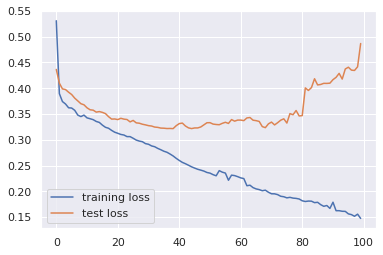

In [116]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


sns.set()
x = np.arange(len(training_losses))
plt.plot(x, training_losses, label = 'training loss')
plt.plot(x, test_losses, label = 'test loss')
plt.legend()

In [160]:
print(confusion_matrix[73])

tensor([[978.,  27.],
        [105., 890.]])


In [63]:
np.argmin(np.array(test_losses))

0

# Module 4
## Evaluation
## HERE We Load the Best Model, try to reproduct test loss and confusion matrix
## We also analysis the wrong predictions

In [6]:
best_model = TreeRNNPredictor()
best_model.load_state_dict(torch.load("best_treeRNN.pt"))
best_model.eval()

TreeRNNPredictor(
  (embedding): Embedding(7, 75)
  (matrix_m): Linear(in_features=150, out_features=75, bias=True)
  (fc_output): Linear(in_features=75, out_features=1, bias=True)
)

In [7]:
confusion_matrix_test = []
error = []

def evaluate(model, criterion):
    
    model.eval()
    epoch_loss = 0
    total = 0
    confusion_matrix_test.append(torch.zeros(2,2))
    global num_epochs
    for i, batch in tqdm(enumerate(test_data)):
        z = best_model.forward(batch[1])
        loss = 0
        loss = criterion(z, torch.tensor([batch[0]]))      
        epoch_loss += loss.item()
        total += 1
        
        # Load in confusion_matrix_test
        
            
        row = int(batch[0])
        col = int(z+0.5)
        confusion_matrix_test[0][row][col] += 1
        if row != col:
            error.append((batch[1], row, col))
     
        
    return epoch_loss/total

In [8]:
evaluate(best_model, criterion)

2000it [00:02, 866.47it/s]


0.32347527070486576

In [9]:
confusion_matrix_test

[tensor([[971.,  34.],
         [107., 888.]])]

In [10]:
def my_printexp(tree):
    if tree.leftChild:
        print('(', end=' ')
        my_printexp(tree.leftChild)
    if tree.isLeaf():
        print(tree.key, end=' ')
    if tree.rightChild:
        my_printexp(tree.rightChild)
        print(')', end=' ')

In [11]:
print(error[0])
my_printexp(error[0][0])


(<pythonds.trees.binaryTree.BinaryTree object at 0x7f6ebb1b7bd0>, 1, 0)
( ( ~ q ) ( <=> ( q ( <=> ( ( q ( | p ) ) ( <=> q ) ) ) ) ) ) 

In [12]:
print(error[1])
my_printexp(error[1][0])

(<pythonds.trees.binaryTree.BinaryTree object at 0x7f6ebb15b1d0>, 0, 1)
( ( ~ p ) ( <=> ( ( q ( & ( q ( & ( p ( & q ) ) ) ) ) ) ( | p ) ) ) ) 

In [13]:
print(error[10])
my_printexp(error[10][0])

(<pythonds.trees.binaryTree.BinaryTree object at 0x7f6ebb0cbb10>, 1, 0)
( ( q ( => ( ~ q ) ) ) ( <=> ( ( q ( & q ) ) ( <=> ( p ( & p ) ) ) ) ) ) 

In [14]:
print(error[11])
my_printexp(error[11][0])

(<pythonds.trees.binaryTree.BinaryTree object at 0x7f6ebb0ce350>, 1, 0)
( ( p ( | ( p ( & p ) ) ) ) ( <=> ( p ( <=> ( ( ( q ( | p ) ) ( => ( ~ p ) ) ) ( <=> ( ( q ( => ( q ( => ( ( ~ q ) ( => ( ( ~ q ) ( | ( ~ ( ~ p ) ) ) ) ) ) ) ) ) ) ( <=> ( ( p ( | p ) ) ( => p ) ) ) ) ) ) ) ) ) ) 

In [15]:
for i in range (20):
    print(error[20+i])
    my_printexp(error[20+i][0])
    print()
    print()

(<pythonds.trees.binaryTree.BinaryTree object at 0x7f6ebb02c7d0>, 1, 0)
( ( ( ~ p ) ( | ( p ( & ( ~ p ) ) ) ) ) ( <=> q ) ) 

(<pythonds.trees.binaryTree.BinaryTree object at 0x7f6ebb032a50>, 1, 0)
( ( ~ ( ~ q ) ) ( <=> ( ( ~ q ) ( <=> ( ( p ( => ( q ( => ( p ( & q ) ) ) ) ) ) ( <=> ( q ( <=> ( q ( | p ) ) ) ) ) ) ) ) ) ) 

(<pythonds.trees.binaryTree.BinaryTree object at 0x7f6ebb0370d0>, 1, 0)
( ( ~ q ) ( <=> ( ( q ( => ( q ( & q ) ) ) ) ( <=> ( ( p ( => ( ( p ( & p ) ) ( => ( ( p ( | ( q ( | ( p ( & ( q ( & p ) ) ) ) ) ) ) ) ( => ( q ( => ( p ( | ( p ( | q ) ) ) ) ) ) ) ) ) ) ) ) ( <=> ( q ( | ( ~ p ) ) ) ) ) ) ) ) ) 

(<pythonds.trees.binaryTree.BinaryTree object at 0x7f6ebafc5910>, 1, 0)
( p ( <=> ( ( ~ q ) ( <=> ( ( ~ p ) ( <=> ( ( ( ~ q ) ( => q ) ) ( <=> ( ( q ( => ( q ( | p ) ) ) ) ( <=> ( ( q ( | p ) ) ( <=> ( q ( <=> q ) ) ) ) ) ) ) ) ) ) ) ) ) ) 

(<pythonds.trees.binaryTree.BinaryTree object at 0x7f6ebaf8a890>, 1, 0)
( q ( <=> ( ( ( ~ ( ~ q ) ) ( => p ) ) ( <=> ( ( ~ p ) ( 

In [16]:
def height(tree):
    if tree == None:
        return -1
    else:
        return 1 + max(height(tree.leftChild),height(tree.rightChild))


In [17]:
# Avg height of the error set
sum = 0
for i in error:
    sum+= height(i[0])
sum/len(error)

9.127659574468085

In [18]:
# Avg height of the test set
sum = 0
for i in test_data:
    sum+= height(i[1])
sum/len(test_data)

8.094

# fregment analysis

In [79]:
e1 = 'p'
e2 = 'q'
e3 = '( ~ p )'
e4 = '( ~ q )'

e5 = '( p ( | q ) )'
e6 = '( p ( & q ) )'

e7 = '( ( ~ p ) ( | q ) )'
e7 = '( ( ~ p ) ( | p ) )'

e8 = '( ( ~ p ) ( & q ) )'
e9 = '( ( ~ q ) ( & q ) )'
e10 = '( ( ~ q ) ( & p ) )'
e11 = '( ( ~ p ) ( & p ) )'


t1 = buildParseTree(e1)
t2 = buildParseTree(e2)
t3 = buildParseTree(e3)
t4 = buildParseTree(e4)
t5 = buildParseTree(e5)
t6 = buildParseTree(e6)
t7 = buildParseTree(e7)
t8 = buildParseTree(e8)
t9 = buildParseTree(e9)
t10 = buildParseTree(e10)
t11 = buildParseTree(e11)

In [80]:
#t1.isLeaf()
print(e1, best_model.forward(t1))
print(e2, best_model.forward(t2))
print(e3, best_model.forward(t3))
print(e4, best_model.forward(t4))
print(e5, best_model.forward(t5))
print(e6, best_model.forward(t6))
print(e7, best_model.forward(t7))
print(e8, best_model.forward(t8))
print(e9, best_model.forward(t9))
print(e10, best_model.forward(t10))
print(e11, best_model.forward(t11))

p tensor([0.9450], grad_fn=<SigmoidBackward0>)
q tensor([1.0000], grad_fn=<SigmoidBackward0>)
( ~ p ) tensor([1.0000], grad_fn=<SigmoidBackward0>)
( ~ q ) tensor([1.], grad_fn=<SigmoidBackward0>)
( p ( | q ) ) tensor([1.], grad_fn=<SigmoidBackward0>)
( p ( & q ) ) tensor([1.], grad_fn=<SigmoidBackward0>)
( ( ~ p ) ( | p ) ) tensor([1.], grad_fn=<SigmoidBackward0>)
( ( ~ p ) ( & q ) ) tensor([0.0106], grad_fn=<SigmoidBackward0>)
( ( ~ q ) ( & q ) ) tensor([0.0122], grad_fn=<SigmoidBackward0>)
( ( ~ q ) ( & p ) ) tensor([0.0122], grad_fn=<SigmoidBackward0>)
( ( ~ p ) ( & p ) ) tensor([0.0078], grad_fn=<SigmoidBackward0>)
